In [1]:
# Importing libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as lines
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter

%matplotlib inline
plt.rcParams['figure.dpi'] = 140
pd.set_option('display.max_columns', None)   #to display all the column information
pd.set_option("max_colwidth", None)

# Background
A hotel booking platform has seen huge growth in the number of hotel bookings made on Mobile devices (Smartphones and Tablets) over the past few years. To make informed recommendations, data on bookings have been provided. These data will provide insights into the drivers of the growth.

## Data wrangling
We import the data and perform important clean-up.

In [ ]:
#definition of column 
col_def = pd.read_excel(r'./bookings_data.xlsx', 
                        sheet_name = 'Definitions', skiprows = 2, 
                        usecols = [1,2], names = [r'Column Name', 'Definitions'])

In [998]:
col_def

,Column Name,Definitions
0,Week,The year and week that the booking took place. 2016-W45 is the week beginning 07/11/2016
1,Platform,"Type of device used to make the booking - Desktop computer, Mobile App (on a Smartphone or Tablet device), or our Mobile website (on a Smartphone or Tablet device)"
2,Super Region,"The region that the traveler originates from (North America, Asia-Pacific, Europe Middle East & Africa or Latin America)"
3,Country Name,The country that the traveler originates from
4,Booking Window Group,"Refers to the number of days between the customer booking and checking into the hotel. E.g. if a customer booked a trip on January 1st and checked in on January 10th, the booking window would be 9 days"
5,Property Country,The country in which the booked hotel is located
6,Net Gross Booking Value USD,The total $ amount that customers pay to Hotels.com for their hotel reservation. The value of cancelled bookings is removed
7,Net Orders,The total number of hotel bookings made - the number of bookings cancelled


In [1009]:
#load data into a dataframe
df = pd.read_excel(r'./bookings_data.xlsx', sheet_name = 'Data')
df.head(5)

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders
0,2016-W45,Desktop,Desktop,APAC,South Korea,8-14 days,Algeria,-608.4244,-3
1,2016-W45,Desktop,Desktop,APAC,South Korea,+90 days,Andorra,-512.1796,-2
2,2016-W45,Desktop,Desktop,APAC,South Korea,46-60 days,Andorra,103.4298,1
3,2016-W45,Desktop,Desktop,APAC,Australia,31-45 days,Argentina,395.9592,1
4,2016-W45,Desktop,Desktop,APAC,Australia,15-30 days,Argentina,373.4194,1


In [1010]:
# Check for missing data

for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100 
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

Super Region null rate: 27.5%


first data issue is the missing data in the **Super Region** column. Let's inspect it and try to fix it.

In [1011]:
df['Super Region'].unique()

array(['APAC', 'EMEA', 'LATAM', nan], dtype=object)

In [1012]:
df[df['Super Region'].isna()]['Country Name'].unique()

array(['US'], dtype=object)

It appears that the **Super Region** for *North America* is missing. we can verify this by looking at the **Country Name**

In [1013]:
df[['Super Region']] = df[['Super Region']].fillna('NA')

In [1014]:
# Drop Duplicates rows if it exists

df.drop_duplicates(inplace= True)

In [1015]:
df.isnull().sum()

Week                           0
Mobile Indicator Name          0
Platform Type Name             0
Super Region                   0
Country Name                   0
Booking Window Group           0
Property Country               0
Net Gross Booking Value USD    0
Net Orders                     0
dtype: int64

Data is free from missing values. We try to carry out feature engineering to im prove the analysis efficiency

In [1016]:
#splitting the year and week as different columns
df[['Year','Week']] = df['Week'].str.split('-', expand=True)
df.head(3)

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year
0,W45,Desktop,Desktop,APAC,South Korea,8-14 days,Algeria,-608.4244,-3,2016
1,W45,Desktop,Desktop,APAC,South Korea,+90 days,Andorra,-512.1796,-2,2016
2,W45,Desktop,Desktop,APAC,South Korea,46-60 days,Andorra,103.4298,1,2016


In [282]:
#function to convert countries to continent
def country_2_continent(country_name, unknown):
    #unknown is dictionary of countries not in the package
    #convert the countries to 2 letter ISO codes
    country_code = []
    for country in country_name:
        if country in unknown.keys():
            country_code.append(unknown[country])
        else:
            country_code.append(pc.country_name_to_country_alpha2(country))

    #convert the country codes into continent codes
    country_continent_code = [pc.country_alpha2_to_continent_code(code) 
                              for code in country_code]

    #convert the continent code into continent name
    country_continent_name = [pc.convert_continent_code_to_continent_name(continent_code) 
                              for continent_code in country_continent_code]
    return country_continent_name

In [283]:
#countries not in the package
country_name = df['Property Country']
unknown={'Curacao':'CW', 'Reunion':'RE', 'Spain & Canary Islands':'ES','Taiwan, Republic of China':'CN',
         "Cote d'ivoire":'CI','Sint Maarten':'NL','U.S. Virgin Islands':'VI','St. Barthelemy':'BL',
         'St. Vincent and the Grenadines':'VC','Cocos Islands':'CC','State of Palestine':'PS'}

df['Property Region'] = country_2_continent(country_name, unknown)

In [284]:
#Converting the country names to continent
country_name = df['Country Name']
unknown = {'US':'US'}

df['Continent Name'] = country_2_continent(country_name, unknown)

In [285]:
##change the US to United States of AMerica for consistency
df.loc[df['Country Name']=='US', 'Country Name'] = 'United States of America'

In [286]:
df['Type of Booking (Country)'] = np.where(df['Country Name']==df['Property Country'], 'Local', 'Non-local')

In [287]:
df['Type of Booking (Region)'] = np.where(df['Continent Name']==df['Property Region'], 'Regional', 'Non-Regional')

In [288]:
df.head()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year,Property Region,Continent Name,Type of Booking (Country),Type of Booking (Region)
0,W45,Desktop,Desktop,APAC,South Korea,8-14 days,Algeria,-608.4244,-3,2016,Africa,Asia,Non-local,Non-Regional
1,W45,Desktop,Desktop,APAC,South Korea,+90 days,Andorra,-512.1796,-2,2016,Europe,Asia,Non-local,Non-Regional
2,W45,Desktop,Desktop,APAC,South Korea,46-60 days,Andorra,103.4298,1,2016,Europe,Asia,Non-local,Non-Regional
3,W45,Desktop,Desktop,APAC,Australia,31-45 days,Argentina,395.9592,1,2016,South America,Oceania,Non-local,Non-Regional
4,W45,Desktop,Desktop,APAC,Australia,15-30 days,Argentina,373.4194,1,2016,South America,Oceania,Non-local,Non-Regional


In [1006]:
df['Week'].nunique()

8

# Data analysis

is there growth in the booking?

In [638]:
data = df.groupby(['Year', 'Mobile Indicator Name'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders         
Year                        2016     2017
Mobile Indicator Name                    
Desktop                  1066185  1211274
Mobile                    470112   786108

In [642]:
data.pct_change(axis=1)*100

Net Orders           
Year                        2016       2017
Mobile Indicator Name                      
Desktop                      NaN  13.608239
Mobile                       NaN  67.217174

Yes, we are seeing a 67% growth in the number of booking in the mobile platform

How is this growth reflected in the mobile platform segement?

In [650]:
data = df.groupby(['Year','Platform Type Name'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders         
Year                     2016     2017
Platform Type Name                    
Desktop               1066185  1211274
Mobile App             183998   332541
Mobile Web             286114   453567

In [651]:
data.pct_change(axis=1)*100

Net Orders           
Year                     2016       2017
Platform Type Name                      
Desktop                   NaN  13.608239
Mobile App                NaN  80.730769
Mobile Web                NaN  58.526671

The App is seeing more growth than the Web.
What percentage of the mobile booking is coming from app and web in 2017 and 2016?

In [301]:
data = df[df['Mobile Indicator Name']=='Mobile'].groupby(['Year','Platform Type Name'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders        
Year                     2016    2017
Platform Type Name                   
Mobile App             183998  332541
Mobile Web             286114  453567

In [343]:
perc = data.iloc[0,:]*100/(data.iloc[1,:] + data.iloc[0,:])
for i in range(len(perc)):
    print("{} accounts for {:.2f}% of net orders in {}".format(data.iloc[0,:].name, perc.values[i], perc.index[i][1]))

Mobile App accounts for 39.14% of net orders in 2016
Mobile App accounts for 42.30% of net orders in 2017


In [345]:
perc = data.iloc[1,:]*100/(data.iloc[1,:] + data.iloc[0,:])
for i in range(len(perc)):
    print("{} accounts for {:.2f}% of net orders in {}".format(data.iloc[1,:].name, perc.values[i], perc.index[i][1]))

Mobile Web accounts for 60.86% of net orders in 2016
Mobile Web accounts for 57.70% of net orders in 2017


How does these net order vary weekly?

In [658]:
data = df[(df['Mobile Indicator Name']=='Mobile')].groupby(['Year','Week','Platform Type Name'])[['Net Orders']].sum().unstack(level=1)
data

Net Orders                        
Week                           W45     W46     W47     W48
Year Platform Type Name                                   
2016 Mobile App              46740   46593   44696   45969
     Mobile Web              71292   74788   68053   71981
2017 Mobile App              89044   81283   83028   79186
     Mobile Web             111251  115847  112503  113966

In [659]:
#percentage change
data.pct_change(axis='columns', periods=1)*100

Net Orders                              
Week                           W45       W46       W47       W48
Year Platform Type Name                                         
2016 Mobile App                NaN -0.314506 -4.071427  2.848130
     Mobile Web                NaN  4.903776 -9.005455  5.771972
2017 Mobile App                NaN -8.715916  2.146820 -4.627355
     Mobile Web                NaN  4.131199 -2.886566  1.300410

Which platform has the more orders in the week?

In [365]:
data = df[(df['Mobile Indicator Name']=='Mobile')&(df['Year']=='2016')].groupby(['Year','Week','Platform Type Name'])[['Net Orders']].sum().unstack(level=1)
data

Net Orders                     
Week                           W45    W46    W47    W48
Year Platform Type Name                                
2016 Mobile App              46740  46593  44696  45969
     Mobile Web              71292  74788  68053  71981

In [366]:
data.apply(lambda x: 100 * x / float(x.sum()))

Net Orders                                 
Week                           W45        W46        W47        W48
Year Platform Type Name                                            
2016 Mobile App          39.599431  38.385744  39.642037  38.973294
     Mobile Web          60.400569  61.614256  60.357963  61.026706

In [367]:
data = df[(df['Mobile Indicator Name']=='Mobile')&(df['Year']=='2017')].groupby(['Year','Week','Platform Type Name'])[['Net Orders']].sum().unstack(level=1)
data

Net Orders                        
Week                           W45     W46     W47     W48
Year Platform Type Name                                   
2017 Mobile App              89044   81283   83028   79186
     Mobile Web             111251  115847  112503  113966

In [368]:
data.apply(lambda x: 100 * x / float(x.sum()))

Net Orders                                 
Week                           W45        W46        W47        W48
Year Platform Type Name                                            
2017 Mobile App          44.456427  41.233196  42.462832  40.996728
     Mobile Web          55.543573  58.766804  57.537168  59.003272

Nothing stands out

How does booking window relate to the platform used?

In [551]:
data = df.groupby(['Year','Mobile Indicator Name','Booking Window Group'])[['Net Orders']].sum().unstack(level=(0,2))
data

Net Orders                                          \
Year                        2016                                           
Booking Window Group    +90 days 0-1 days 15-30 days 2-3 days 31-45 days   
Mobile Indicator Name                                                      
Desktop                    51604   274786     162988   127993      84014   
Mobile                     12261   254645      40639    45964      20999   

                                                                          \
Year                                                                       
Booking Window Group  4-7 days 46-60 days 61-90 days 8-14 days Post Book   
Mobile Indicator Name                                                      
Desktop                 155893      40338      29839    137924       806   
Mobile                   45049       9207       6525     34808        15   

                                                                        \
Year                      2017                                           
Booking Window Group  +90 days 0-1 days 15-30 days 2-3 days 31-45 days   
Mobile Indicator Name                                                    
Desktop                  60266   295804     185534   147602      94160   
Mobile                   21865   396725      72774    80246      37782   

                                                                          
Year                                                                      
Booking Window Group  4-7 days 46-60 days 61-90 days 8-14 days Post Book  
Mobile Indicator Name                                                     
Desktop                 181803      47213      35004    163201       687  
Mobile                   79223      18321      13262     64803      1107

In [552]:
data.apply(lambda x: 100 * x / float(x.sum()))

Net Orders                                              \
Year                        2016                                               
Booking Window Group    +90 days   0-1 days 15-30 days   2-3 days 31-45 days   
Mobile Indicator Name                                                          
Desktop                80.801691  51.902136  80.042431  73.577378  80.003428   
Mobile                 19.198309  48.097864  19.957569  26.422622  19.996572   

                                                                             \
Year                                                                          
Booking Window Group    4-7 days 46-60 days 61-90 days  8-14 days Post Book   
Mobile Indicator Name                                                         
Desktop                77.581093  81.416894  82.056429  79.848552  98.17296   
Mobile                 22.418907  18.583106  17.943571  20.151448   1.82704   

                                                                             \
Year                        2017                                              
Booking Window Group    +90 days  0-1 days 15-30 days   2-3 days 31-45 days   
Mobile Indicator Name                                                         
Desktop                73.377896  42.71359  71.826657  64.780907  71.364691   
Mobile                 26.622104  57.28641  28.173343  35.219093  28.635309   

                                                                             
Year                                                                         
Booking Window Group    4-7 days 46-60 days 61-90 days 8-14 days  Post Book  
Mobile Indicator Name                                                        
Desktop                69.649384  72.043519  72.523101  71.57813  38.294314  
Mobile                 30.350616  27.956481  27.476899  28.42187  61.705686

In [553]:
data = df.groupby(['Year','Mobile Indicator Name','Booking Window Group'])[['Net Orders']].sum().unstack(level=(0))
data

Net Orders        
Year                                             2016    2017
Mobile Indicator Name Booking Window Group                   
Desktop               +90 days                  51604   60266
                      0-1 days                 274786  295804
                      15-30 days               162988  185534
                      2-3 days                 127993  147602
                      31-45 days                84014   94160
                      4-7 days                 155893  181803
                      46-60 days                40338   47213
                      61-90 days                29839   35004
                      8-14 days                137924  163201
                      Post Book                   806     687
Mobile                +90 days                  12261   21865
                      0-1 days                 254645  396725
                      15-30 days                40639   72774
                      2-3 days                  45964   80246
                      31-45 days                20999   37782
                      4-7 days                  45049   79223
                      46-60 days                 9207   18321
                      61-90 days                 6525   13262
                      8-14 days                 34808   64803
                      Post Book                    15    1107

In [554]:
data.pct_change(axis='columns', periods=1)*100

Net Orders             
Year                                             2016         2017
Mobile Indicator Name Booking Window Group                        
Desktop               +90 days                    NaN    16.785521
                      0-1 days                    NaN     7.648861
                      15-30 days                  NaN    13.832920
                      2-3 days                    NaN    15.320369
                      31-45 days                  NaN    12.076559
                      4-7 days                    NaN    16.620374
                      46-60 days                  NaN    17.043483
                      61-90 days                  NaN    17.309561
                      8-14 days                   NaN    18.326760
                      Post Book                   NaN   -14.764268
Mobile                +90 days                    NaN    78.329663
                      0-1 days                    NaN    55.795323
                      15-30 days                  NaN    79.074288
                      2-3 days                    NaN    74.584457
                      31-45 days                  NaN    79.922853
                      4-7 days                    NaN    75.859620
                      46-60 days                  NaN    98.989899
                      61-90 days                  NaN   103.249042
                      8-14 days                   NaN    86.172719
                      Post Book                   NaN  7280.000000

What kind of people use the app in terms of booking window?

In [558]:
data = df[(df['Mobile Indicator Name']=='Mobile')].groupby(['Year','Platform Type Name','Booking Window Group'])[['Net Orders']].sum().unstack(level=(0,2))
data

Net Orders                                          \
Year                       2016                                           
Booking Window Group   +90 days 0-1 days 15-30 days 2-3 days 31-45 days   
Platform Type Name                                                        
Mobile App                 3223   110753      12881    17454       6790   
Mobile Web                 9038   143892      27758    28510      14209   

                                                                         \
Year                                                                      
Booking Window Group 4-7 days 46-60 days 61-90 days 8-14 days Post Book   
Platform Type Name                                                        
Mobile App              16084       3155       2218     11440         0   
Mobile Web              28965       6052       4307     23368        15   

                                                                       \
Year                     2017                                           
Booking Window Group +90 days 0-1 days 15-30 days 2-3 days 31-45 days   
Platform Type Name                                                      
Mobile App               7253   175469      28080    34026      15201   
Mobile Web              14612   221256      44694    46220      22581   

                                                                         
Year                                                                     
Booking Window Group 4-7 days 46-60 days 61-90 days 8-14 days Post Book  
Platform Type Name                                                       
Mobile App              32626       7960       6290     25136       500  
Mobile Web              46597      10361       6972     39667       607

In [559]:
data.apply(lambda x: 100 * x / float(x.sum()))

Net Orders                                              \
Year                       2016                                               
Booking Window Group   +90 days   0-1 days 15-30 days   2-3 days 31-45 days   
Platform Type Name                                                            
Mobile App              26.2866  43.493098  31.696154  37.973196  32.334873   
Mobile Web              73.7134  56.506902  68.303846  62.026804  67.665127   

                                                                            \
Year                                                                         
Booking Window Group   4-7 days 46-60 days 61-90 days  8-14 days Post Book   
Platform Type Name                                                           
Mobile App            35.703345  34.267405  33.992337  32.866008       0.0   
Mobile Web            64.296655  65.732595  66.007663  67.133992     100.0   

                                                                             \
Year                       2017                                               
Booking Window Group   +90 days   0-1 days 15-30 days   2-3 days 31-45 days   
Platform Type Name                                                            
Mobile App            33.171736  44.229378  38.585209  42.402114  40.233444   
Mobile Web            66.828264  55.770622  61.414791  57.597886  59.766556   

                                                                             
Year                                                                         
Booking Window Group   4-7 days 46-60 days 61-90 days  8-14 days  Post Book  
Platform Type Name                                                           
Mobile App            41.182485   43.44741  47.428744  38.788328  45.167118  
Mobile Web            58.817515   56.55259  52.571256  61.211672  54.832882

In [648]:
data = df[(df['Mobile Indicator Name']=='Mobile')].groupby(['Year','Platform Type Name','Booking Window Group'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders        
Year                                          2016    2017
Platform Type Name Booking Window Group                   
Mobile App         +90 days                   3223    7253
                   0-1 days                 110753  175469
                   15-30 days                12881   28080
                   2-3 days                  17454   34026
                   31-45 days                 6790   15201
                   4-7 days                  16084   32626
                   46-60 days                 3155    7960
                   61-90 days                 2218    6290
                   8-14 days                 11440   25136
                   Post Book                     0     500
Mobile Web         +90 days                   9038   14612
                   0-1 days                 143892  221256
                   15-30 days                27758   44694
                   2-3 days                  28510   46220
                   31-45 days                14209   22581
                   4-7 days                  28965   46597
                   46-60 days                 6052   10361
                   61-90 days                 4307    6972
                   8-14 days                 23368   39667
                   Post Book                    15     607

In [649]:
data.pct_change(axis='columns', periods=1)*100

Net Orders             
Year                                          2016         2017
Platform Type Name Booking Window Group                        
Mobile App         +90 days                    NaN   125.038784
                   0-1 days                    NaN    58.432729
                   15-30 days                  NaN   117.995497
                   2-3 days                    NaN    94.946717
                   31-45 days                  NaN   123.873343
                   4-7 days                    NaN   102.847550
                   46-60 days                  NaN   152.297940
                   61-90 days                  NaN   183.588819
                   8-14 days                   NaN   119.720280
                   Post Book                   NaN          inf
Mobile Web         +90 days                    NaN    61.672936
                   0-1 days                    NaN    53.765324
                   15-30 days                  NaN    61.013041
                   2-3 days                    NaN    62.118555
                   31-45 days                  NaN    58.920403
                   4-7 days                    NaN    60.873468
                   46-60 days                  NaN    71.199603
                   61-90 days                  NaN    61.876016
                   8-14 days                   NaN    69.749230
                   Post Book                   NaN  3946.666667

How did the booking platform change with region of booking?

In [931]:
data = df[df['Mobile Indicator Name']=='Mobile'].groupby(['Year', 'Super Region'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders        
Year               2016    2017
Super Region                   
APAC              36862   89324
EMEA              48801   84694
LATAM              6883   14399
NA               377566  597691

In [400]:
data.apply(lambda x: 100*x/float(x.sum()))

Net Orders           
Year               2016       2017
Super Region                      
APAC           8.346303  10.312749
EMEA          12.290592  12.998515
LATAM          2.386583   2.801417
NA            76.976522  73.887318

In [401]:
data.pct_change(axis='columns',periods=1)*100

Net Orders           
Year               2016       2017
Super Region                      
APAC                NaN  60.644653
EMEA                NaN  37.501324
LATAM               NaN  52.611482
NA                  NaN  24.795110

Which platform is this growth coming from?

In [404]:
data = df.groupby(['Year', 'Mobile Indicator Name', 'Super Region'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders        
Year                                     2016    2017
Mobile Indicator Name Super Region                   
Desktop               APAC              91362  116661
                      EMEA             140019  174936
                      LATAM             29782   41556
                      NA               805022  878121
Mobile                APAC              36862   89324
                      EMEA              48801   84694
                      LATAM              6883   14399
                      NA               377566  597691

In [405]:
data.pct_change(axis='columns',periods=1)*100

Net Orders            
Year                                     2016        2017
Mobile Indicator Name Super Region                       
Desktop               APAC                NaN   27.690944
                      EMEA                NaN   24.937330
                      LATAM               NaN   39.533947
                      NA                  NaN    9.080373
Mobile                APAC                NaN  142.320004
                      EMEA                NaN   73.549722
                      LATAM               NaN  109.196571
                      NA                  NaN   58.301065

The growth in the Mobile platform, is it app or web specific?

In [407]:
data = df[df['Mobile Indicator Name']=='Mobile'].groupby(['Year', 'Platform Type Name', 'Super Region'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders        
Year                                  2016    2017
Platform Type Name Super Region                   
Mobile App         APAC              19964   57242
                   EMEA              16505   30030
                   LATAM              2380    6459
                   NA               145149  238810
Mobile Web         APAC              16898   32082
                   EMEA              32296   54664
                   LATAM              4503    7940
                   NA               232417  358881

In [408]:
data.pct_change(axis='columns',periods=1)*100

Net Orders            
Year                                  2016        2017
Platform Type Name Super Region                       
Mobile App         APAC                NaN  186.726107
                   EMEA                NaN   81.944865
                   LATAM               NaN  171.386555
                   NA                  NaN   64.527486
Mobile Web         APAC                NaN   89.856788
                   EMEA                NaN   69.259351
                   LATAM               NaN   76.326893
                   NA                  NaN   54.412543

The growth of Mobile App in APAC and LATAM is significant.

Is there are specific country this growth can be attributed to?

In [445]:
data = df[df['Mobile Indicator Name']=='Mobile'].groupby(['Year', 'Platform Type Name','Country Name'])[['Net Orders']].sum().unstack(level=(0,2))
data

Net Orders                                      \
Year                     2016                                       
Country Name        Australia Brazil Hong Kong Norway South Korea   
Platform Type Name                                                  
Mobile App               3758   2380      5459   3084       10747   
Mobile Web               6858   4503      4504   5780        5536   

                                                                             \
Year                                                            2017          
Country Name       United Kingdom United States of America Australia Brazil   
Platform Type Name                                                            
Mobile App                  13421                   145149      7418   6459   
Mobile Web                  26516                   232417      9470   7940   

                                                                \
Year                                                             
Country Name       Hong Kong Norway South Korea United Kingdom   
Platform Type Name                                               
Mobile App             14326   5273       35498          24757   
Mobile Web              7681   8280       14931          46384   

                                             
Year                                         
Country Name       United States of America  
Platform Type Name                           
Mobile App                           238810  
Mobile Web                           358881

In [446]:
data.apply(lambda x: 100*x/float(x.sum()))

Net Orders                                               \
Year                     2016                                                
Country Name        Australia     Brazil  Hong Kong     Norway South Korea   
Platform Type Name                                                           
Mobile App          35.399397  34.577946  54.792733  34.792419   66.001351   
Mobile Web          64.600603  65.422054  45.207267  65.207581   33.998649   

                                                                      \
Year                                                            2017   
Country Name       United Kingdom United States of America Australia   
Platform Type Name                                                     
Mobile App              33.605429                38.443345  43.92468   
Mobile Web              66.394571                61.556655  56.07532   

                                                                 \
Year                                                              
Country Name           Brazil  Hong Kong     Norway South Korea   
Platform Type Name                                                
Mobile App          44.857282  65.097469  38.906515   70.392036   
Mobile Web          55.142718  34.902531  61.093485   29.607964   

                                                            
Year                                                        
Country Name       United Kingdom United States of America  
Platform Type Name                                          
Mobile App              34.799904                39.955428  
Mobile Web              65.200096                60.044572

In [932]:
data = df[df['Mobile Indicator Name']=='Mobile'].groupby(['Year', 'Super Region','Country Name'])[['Net Orders']].sum().unstack(level=0)
data

Net Orders        
Year                                        2016    2017
Super Region Country Name                               
APAC         Australia                     10616   16888
             Hong Kong                      9963   22007
             South Korea                   16283   50429
EMEA         Norway                         8864   13553
             United Kingdom                39937   71141
LATAM        Brazil                         6883   14399
NA           United States of America     377566  597691

In [934]:
data.apply(lambda x: x*100/float(x.sum()))

Net Orders           
Year                                        2016       2017
Super Region Country Name                                  
APAC         Australia                  2.258185   2.148305
             Hong Kong                  2.119282   2.799488
             South Korea                3.463643   6.415022
EMEA         Norway                     1.885508   1.724063
             United Kingdom             8.495210   9.049774
LATAM        Brazil                     1.464119   1.831682
NA           United States of America  80.314053  76.031665

In [789]:
data.pct_change(axis='columns',periods=1)*100

Net Orders            
Year                                        2016        2017
Super Region Country Name                                   
APAC         Australia                       NaN   59.080633
             Hong Kong                       NaN  120.887283
             South Korea                     NaN  209.703372
EMEA         Norway                          NaN   52.899368
             United Kingdom                  NaN   78.133060
LATAM        Brazil                          NaN  109.196571
NA           United States of America        NaN   58.301065

What is the booking pattern? domestic or international

In [938]:
data = df[(df['Mobile Indicator Name']=='Mobile')&(df['Country Name']!='United States of America')].groupby(['Year', 'Type of Booking (Country)'])[['Net Orders']].sum().unstack(level=(0))
data

Net Orders       
Year                            2016   2017
Type of Booking (Country)                  
Local                          46867  93581
Non-local                      45679  94836

In [454]:
data = df[(df['Mobile Indicator Name']=='Mobile')].groupby(['Year', 'Country Name', 'Type of Booking (Country)'])[['Net Orders']].sum().unstack(level=(0,1))
data

Net Orders                                      \
Year                            2016                                       
Country Name               Australia Brazil Hong Kong Norway South Korea   
Type of Booking (Country)                                                  
Local                           6455   3565      2807   3195        5074   
Non-local                       4161   3318      7156   5669       11209   

                                                                             \
Year                                                                   2017   
Country Name              United Kingdom United States of America Australia   
Type of Booking (Country)                                                     
Local                              25771                   349282     11103   
Non-local                          14166                    28284      5785   

                                                                              \
Year                                                                           
Country Name              Brazil Hong Kong Norway South Korea United Kingdom   
Type of Booking (Country)                                                      
Local                       9231      5924   6035       14726          46562   
Non-local                   5168     16083   7518       35703          24579   

                                                    
Year                                                
Country Name              United States of America  
Type of Booking (Country)                           
Local                                       546716  
Non-local                                    50975

In [455]:
data.apply(lambda x:100*x/float(x.sum()))

Net Orders                                   \
Year                            2016                                    
Country Name               Australia     Brazil  Hong Kong     Norway   
Type of Booking (Country)                                               
Local                      60.804446  51.794276  28.174245  36.044675   
Non-local                  39.195554  48.205724  71.825755  63.955325   

                                                                               \
Year                                                                            
Country Name              South Korea United Kingdom United States of America   
Type of Booking (Country)                                                       
Local                       31.161334      64.529133                92.508859   
Non-local                   68.838666      35.470867                 7.491141   

                                                                       \
Year                            2017                                    
Country Name               Australia     Brazil  Hong Kong     Norway   
Type of Booking (Country)                                               
Local                      65.744908  64.108619  26.918708  44.528887   
Non-local                  34.255092  35.891381  73.081292  55.471113   

                                                                               
Year                                                                           
Country Name              South Korea United Kingdom United States of America  
Type of Booking (Country)                                                      
Local                       29.201452      65.450303                91.471346  
Non-local                   70.798548      34.549697                 8.528654

How did this change over the years?

In [823]:
data = df[(df['Mobile Indicator Name']=='Mobile')].groupby(['Year', 'Country Name', 'Type of Booking (Country)'])[['Net Orders']].sum().unstack(level=(0))
data

Net Orders        
Year                                                     2016    2017
Country Name             Type of Booking (Country)                   
Australia                Local                           6455   11103
                         Non-local                       4161    5785
Brazil                   Local                           3565    9231
                         Non-local                       3318    5168
Hong Kong                Local                           2807    5924
                         Non-local                       7156   16083
Norway                   Local                           3195    6035
                         Non-local                       5669    7518
South Korea              Local                           5074   14726
                         Non-local                      11209   35703
United Kingdom           Local                          25771   46562
                         Non-local                      14166   24579
United States of America Local                         349282  546716
                         Non-local                      28284   50975

In [826]:
data.pct_change(axis=1)*100

Net Orders            
Year                                                     2016        2017
Country Name             Type of Booking (Country)                       
Australia                Local                            NaN   72.006197
                         Non-local                        NaN   39.029080
Brazil                   Local                            NaN  158.934081
                         Non-local                        NaN   55.756480
Hong Kong                Local                            NaN  111.043819
                         Non-local                        NaN  124.748463
Norway                   Local                            NaN   88.888889
                         Non-local                        NaN   32.615982
South Korea              Local                            NaN  190.224675
                         Non-local                        NaN  218.520831
United Kingdom           Local                            NaN   80.675954
                         Non-local                        NaN   73.506989
United States of America Local                            NaN   56.525673
                         Non-local                        NaN   80.225569

where are these international travelers going?

In [834]:
data = df[(df['Mobile Indicator Name']=='Mobile')&(df['Type of Booking (Country)']=='Non-local')&(df['Year']=='2017')].groupby(['Country Name','Property Country'])[['Net Orders']].sum().unstack(level=(0))
data

Net Orders                                      \
Country Name      Australia Brazil Hong Kong Norway South Korea   
Property Country                                                  
Albania                 1.0    NaN       NaN    NaN         NaN   
Algeria                 NaN    0.0       NaN    1.0         1.0   
American Samoa          NaN    NaN       NaN    NaN         NaN   
Andorra                 NaN    2.0       NaN    1.0         1.0   
Angola                  NaN    NaN       NaN    NaN         NaN   
...                     ...    ...       ...    ...         ...   
Vanuatu                 7.0    NaN       NaN    NaN         NaN   
Venezuela               NaN    1.0       NaN    0.0         NaN   
Vietnam               192.0   21.0     210.0  135.0      1864.0   
Zambia                  1.0    NaN       NaN    NaN         3.0   
Zimbabwe                2.0    NaN       1.0    NaN         4.0   

                                                          
Country Name     United Kingdom United States of America  
Property Country                                          
Albania                     7.0                      5.0  
Algeria                     2.0                      1.0  
American Samoa              NaN                      2.0  
Andorra                    10.0                      4.0  
Angola                      0.0                      NaN  
...                         ...                      ...  
Vanuatu                     1.0                      6.0  
Venezuela                   1.0                     14.0  
Vietnam                   450.0                    827.0  
Zambia                      0.0                     11.0  
Zimbabwe                   16.0                     11.0  

[185 rows x 7 columns]

In [833]:
data.sum(axis=1).sort_values(ascending=False).head(5)

Property Country
Japan                       15350.0
United States of America    11140.0
Thailand                    10595.0
Italy                        5887.0
Mexico                       5767.0
dtype: float64

In [840]:
perc = data.apply(lambda x: x*100/float(x.sum()))
cnt = perc.apply(lambda x: x.nlargest(5))
cnt

Net Orders                                   \
Country Name               Australia     Brazil  Hong Kong     Norway   
Canada                           NaN        NaN        NaN        NaN   
China                            NaN        NaN   7.853012        NaN   
Denmark                          NaN        NaN        NaN   6.610801   
France                           NaN   3.850619        NaN        NaN   
Indonesia                  10.821089        NaN        NaN        NaN   
Ireland                          NaN        NaN        NaN        NaN   
Italy                            NaN   8.184985        NaN        NaN   
Japan                       4.788245        NaN  27.525959        NaN   
Mexico                           NaN        NaN        NaN        NaN   
New Zealand                 9.178911        NaN        NaN        NaN   
Portugal                         NaN   4.198916        NaN        NaN   
South Korea                      NaN        NaN   7.193931        NaN   
Spain & Canary Islands           NaN   3.811920        NaN        NaN   
Sweden                           NaN        NaN        NaN  10.734238   
Taiwan, Republic of China        NaN        NaN  19.480196        NaN   
Thailand                    9.749352        NaN   9.637505   9.284384   
United Kingdom                   NaN        NaN        NaN  10.734238   
United States of America   17.441659  44.020898        NaN  11.505720   
Vietnam                          NaN        NaN        NaN        NaN   

                                                                               
Country Name              South Korea United Kingdom United States of America  
Canada                            NaN            NaN                 9.600785  
China                             NaN            NaN                      NaN  
Denmark                           NaN            NaN                      NaN  
France                            NaN       5.838317                      NaN  
Indonesia                         NaN            NaN                      NaN  
Ireland                           NaN       7.384352                      NaN  
Italy                             NaN            NaN                 4.039235  
Japan                       24.227656            NaN                      NaN  
Mexico                            NaN            NaN                10.346248  
New Zealand                       NaN            NaN                      NaN  
Portugal                          NaN            NaN                      NaN  
South Korea                       NaN            NaN                      NaN  
Spain & Canary Islands            NaN       7.661011                      NaN  
Sweden                            NaN            NaN                      NaN  
Taiwan, Republic of China    5.380500            NaN                      NaN  
Thailand                     8.136571       7.189064                 5.857773  
United Kingdom                    NaN            NaN                 4.227563  
United States of America     9.668655      13.104683                      NaN  
Vietnam                      5.220850            NaN                      NaN

In [688]:
# des = data.apply(lambda x: x.idxmax())
cnt = data.apply(lambda x: x.nlargest(3))
# pd.concat([des,cnt],axis=1).unstack(level=1)
cnt

Net Orders                                       \
Country Name               Australia  Brazil Hong Kong Norway South Korea   
Canada                           NaN     NaN       NaN    NaN         NaN   
Indonesia                      626.0     NaN       NaN    NaN         NaN   
Ireland                          NaN     NaN       NaN    NaN         NaN   
Italy                            NaN   423.0       NaN    NaN         NaN   
Japan                            NaN     NaN    4427.0    NaN      8650.0   
Mexico                           NaN     NaN       NaN    NaN         NaN   
Portugal                         NaN   217.0       NaN    NaN         NaN   
Spain & Canary Islands           NaN     NaN       NaN    NaN         NaN   
Sweden                           NaN     NaN       NaN  807.0         NaN   
Taiwan, Republic of China        NaN     NaN    3133.0    NaN         NaN   
Thailand                       564.0     NaN    1550.0    NaN      2905.0   
United Kingdom                   NaN     NaN       NaN  807.0         NaN   
United States of America      1009.0  2275.0       NaN  865.0      3452.0   

                                                                   
Country Name              United Kingdom United States of America  
Canada                               NaN                   4894.0  
Indonesia                            NaN                      NaN  
Ireland                           1815.0                      NaN  
Italy                                NaN                      NaN  
Japan                                NaN                      NaN  
Mexico                               NaN                   5274.0  
Portugal                             NaN                      NaN  
Spain & Canary Islands            1883.0                      NaN  
Sweden                               NaN                      NaN  
Taiwan, Republic of China            NaN                      NaN  
Thailand                             NaN                   2986.0  
United Kingdom                       NaN                      NaN  
United States of America          3221.0                      NaN

In [495]:
cnt.rank(ascending=False)

Net Orders                                      \
Country Name               Australia Brazil Hong Kong Norway South Korea   
Canada                           NaN    NaN       NaN    NaN         NaN   
Indonesia                        2.0    NaN       NaN    NaN         NaN   
Ireland                          NaN    NaN       NaN    NaN         NaN   
Italy                            NaN    2.0       NaN    NaN         NaN   
Japan                            NaN    NaN       1.0    NaN         1.0   
Mexico                           NaN    NaN       NaN    NaN         NaN   
Portugal                         NaN    3.0       NaN    NaN         NaN   
Spain & Canary Islands           NaN    NaN       NaN    NaN         NaN   
Sweden                           NaN    NaN       NaN    2.5         NaN   
Taiwan, Republic of China        NaN    NaN       2.0    NaN         NaN   
Thailand                         3.0    NaN       3.0    NaN         3.0   
United Kingdom                   NaN    NaN       NaN    2.5         NaN   
United States of America         1.0    1.0       NaN    1.0         2.0   

                                                                   
Country Name              United Kingdom United States of America  
Canada                               NaN                      2.0  
Indonesia                            NaN                      NaN  
Ireland                              3.0                      NaN  
Italy                                NaN                      NaN  
Japan                                NaN                      NaN  
Mexico                               NaN                      1.0  
Portugal                             NaN                      NaN  
Spain & Canary Islands               2.0                      NaN  
Sweden                               NaN                      NaN  
Taiwan, Republic of China            NaN                      NaN  
Thailand                             NaN                      3.0  
United Kingdom                       NaN                      NaN  
United States of America             1.0                      NaN

In [829]:
## 2016
data = df[(df['Mobile Indicator Name']=='Mobile')&(df['Type of Booking (Country)']=='Non-local')&(df['Year']=='2016')].groupby(['Country Name','Property Country'])[['Net Orders']].sum().unstack(level=(0))
data

Net Orders                                      \
Country Name      Australia Brazil Hong Kong Norway South Korea   
Property Country                                                  
Albania                 NaN    NaN       NaN    NaN         NaN   
Algeria                 NaN    NaN       NaN    NaN         1.0   
American Samoa          NaN    NaN       NaN    NaN         NaN   
Andorra                 NaN    NaN       NaN    1.0         1.0   
Angola                  NaN    NaN       NaN    NaN         NaN   
...                     ...    ...       ...    ...         ...   
Vanuatu                10.0    NaN       NaN    NaN         NaN   
Venezuela               1.0    1.0       NaN    NaN         1.0   
Vietnam               145.0    4.0      44.0   76.0       341.0   
Zambia                  2.0    NaN       NaN    NaN         NaN   
Zimbabwe                3.0    NaN       NaN    1.0         3.0   

                                                          
Country Name     United Kingdom United States of America  
Property Country                                          
Albania                     2.0                      6.0  
Algeria                     2.0                      5.0  
American Samoa              NaN                      2.0  
Andorra                     1.0                      2.0  
Angola                      NaN                      1.0  
...                         ...                      ...  
Vanuatu                     2.0                      NaN  
Venezuela                   1.0                      3.0  
Vietnam                   235.0                    387.0  
Zambia                      3.0                      6.0  
Zimbabwe                    5.0                      5.0  

[176 rows x 7 columns]

In [830]:
data.sum(axis=1).sort_values(ascending=False).head(10)

Property Country
United States of America    6892.0
Japan                       5002.0
Thailand                    4346.0
Canada                      3237.0
France                      3226.0
Italy                       3187.0
United Kingdom              3163.0
Mexico                      2899.0
Spain & Canary Islands      2715.0
Germany                     2644.0
dtype: float64

In [685]:
cnt = data.apply(lambda x: x.nlargest(3))
cnt.rank(ascending=False)

Net Orders                                      \
Country Name               Australia Brazil Hong Kong Norway South Korea   
Argentina                        NaN    3.0       NaN    NaN         NaN   
Canada                           NaN    NaN       NaN    NaN         NaN   
China                            NaN    NaN       3.0    NaN         NaN   
France                           NaN    NaN       NaN    NaN         NaN   
Indonesia                        3.0    NaN       NaN    NaN         NaN   
Ireland                          NaN    NaN       NaN    NaN         NaN   
Italy                            NaN    2.0       NaN    NaN         NaN   
Japan                            NaN    NaN       1.0    NaN         1.0   
Mexico                           NaN    NaN       NaN    NaN         NaN   
New Zealand                      2.0    NaN       NaN    NaN         NaN   
Sweden                           NaN    NaN       NaN    3.0         NaN   
Taiwan, Republic of China        NaN    NaN       2.0    NaN         NaN   
Thailand                         NaN    NaN       NaN    NaN         3.0   
United Kingdom                   NaN    NaN       NaN    2.0         NaN   
United States of America         1.0    1.0       NaN    1.0         2.0   

                                                                   
Country Name              United Kingdom United States of America  
Argentina                            NaN                      NaN  
Canada                               NaN                      1.0  
China                                NaN                      NaN  
France                               2.0                      NaN  
Indonesia                            NaN                      NaN  
Ireland                              3.0                      NaN  
Italy                                NaN                      NaN  
Japan                                NaN                      NaN  
Mexico                               NaN                      2.0  
New Zealand                          NaN                      NaN  
Sweden                               NaN                      NaN  
Taiwan, Republic of China            NaN                      NaN  
Thailand                             NaN                      NaN  
United Kingdom                       NaN                      3.0  
United States of America             1.0                      NaN

In [689]:
cnt.rank(ascending=False)

Net Orders                                      \
Country Name               Australia Brazil Hong Kong Norway South Korea   
Canada                           NaN    NaN       NaN    NaN         NaN   
Indonesia                        2.0    NaN       NaN    NaN         NaN   
Ireland                          NaN    NaN       NaN    NaN         NaN   
Italy                            NaN    2.0       NaN    NaN         NaN   
Japan                            NaN    NaN       1.0    NaN         1.0   
Mexico                           NaN    NaN       NaN    NaN         NaN   
Portugal                         NaN    3.0       NaN    NaN         NaN   
Spain & Canary Islands           NaN    NaN       NaN    NaN         NaN   
Sweden                           NaN    NaN       NaN    2.5         NaN   
Taiwan, Republic of China        NaN    NaN       2.0    NaN         NaN   
Thailand                         3.0    NaN       3.0    NaN         3.0   
United Kingdom                   NaN    NaN       NaN    2.5         NaN   
United States of America         1.0    1.0       NaN    1.0         2.0   

                                                                   
Country Name              United Kingdom United States of America  
Canada                               NaN                      2.0  
Indonesia                            NaN                      NaN  
Ireland                              3.0                      NaN  
Italy                                NaN                      NaN  
Japan                                NaN                      NaN  
Mexico                               NaN                      1.0  
Portugal                             NaN                      NaN  
Spain & Canary Islands               2.0                      NaN  
Sweden                               NaN                      NaN  
Taiwan, Republic of China            NaN                      NaN  
Thailand                             NaN                      3.0  
United Kingdom                       NaN                      NaN  
United States of America             1.0                      NaN

International or Domestic bookings by platform?

In [523]:
data = df[(df['Mobile Indicator Name']=='Mobile')].groupby(['Year','Platform Type Name','Type of Booking (Country)','Country Name'])[['Net Orders']].sum().unstack(level=(0))
data

Net Orders  \
Year                                                                        2016   
Platform Type Name Type of Booking (Country) Country Name                          
Mobile App         Local                     Australia                      2108   
                                             Brazil                         1383   
                                             Hong Kong                      1779   
                                             Norway                         1178   
                                             South Korea                    3359   
                                             United Kingdom                 8465   
                                             United States of America     130955   
                   Non-local                 Australia                      1650   
                                             Brazil                          997   
                                             Hong Kong                      3680   
                                             Norway                         1906   
                                             South Korea                    7388   
                                             United Kingdom                 4956   
                                             United States of America      14194   
Mobile Web         Local                     Australia                      4347   
                                             Brazil                         2182   
                                             Hong Kong                      1028   
                                             Norway                         2017   
                                             South Korea                    1715   
                                             United Kingdom                17306   
                                             United States of America     218327   
                   Non-local                 Australia                      2511   
                                             Brazil                         2321   
                                             Hong Kong                      3476   
                                             Norway                         3763   
                                             South Korea                    3821   
                                             United Kingdom                 9210   
                                             United States of America      14090   

                                                                               
Year                                                                     2017  
Platform Type Name Type of Booking (Country) Country Name                      
Mobile App         Local                     Australia                   4481  
                                             Brazil                      3801  
                                             Hong Kong                   4018  
                                             Norway                      2272  
                                             South Korea                 9926  
                                             United Kingdom             15071  
                                             United States of America  209968  
                   Non-local                 Australia                   2937  
                                             Brazil                      2658  
                                             Hong Kong                  10308  
                                             Norway                      3001  
                                             South Korea                25572  
                                             United Kingdom              9686  
                                             United States of America   28842  
Mobile Web         Local                     Australia                   6622  
                         

In [524]:
data.pct_change(axis=1,periods=1)*100

Net Orders  \
Year                                                                        2016   
Platform Type Name Type of Booking (Country) Country Name                          
Mobile App         Local                     Australia                       NaN   
                                             Brazil                          NaN   
                                             Hong Kong                       NaN   
                                             Norway                          NaN   
                                             South Korea                     NaN   
                                             United Kingdom                  NaN   
                                             United States of America        NaN   
                   Non-local                 Australia                       NaN   
                                             Brazil                          NaN   
                                             Hong Kong                       NaN   
                                             Norway                          NaN   
                                             South Korea                     NaN   
                                             United Kingdom                  NaN   
                                             United States of America        NaN   
Mobile Web         Local                     Australia                       NaN   
                                             Brazil                          NaN   
                                             Hong Kong                       NaN   
                                             Norway                          NaN   
                                             South Korea                     NaN   
                                             United Kingdom                  NaN   
                                             United States of America        NaN   
                   Non-local                 Australia                       NaN   
                                             Brazil                          NaN   
                                             Hong Kong                       NaN   
                                             Norway                          NaN   
                                             South Korea                     NaN   
                                             United Kingdom                  NaN   
                                             United States of America        NaN   

                                                                                   
Year                                                                         2017  
Platform Type Name Type of Booking (Country) Country Name                          
Mobile App         Local                     Australia                 112.571157  
                                             Brazil                    174.837310  
                                             Hong Kong                 125.857223  
                                             Norway                     92.869270  
                                             South Korea               195.504614  
                                             United Kingdom             78.038984  
                                             United States of America   60.335993  
                   Non-local                 Australia                  78.000000  
                                             Brazil                    166.599799  
                                             Hong Kong                 180.108696  
                                             Norway                     57.450157  
                                             South Korea               246.128858  
                                             United Kingdom             95.439871  
                                             United States of America  103.198535  
Mobile Web         Local             

In [541]:
data.unstack(level=(2)).apply(lambda x: 100*x/float(x.sum()))

Net Orders                        \
Year                                               2016                         
Country Name                                  Australia     Brazil  Hong Kong   
Platform Type Name Type of Booking (Country)                                    
Mobile App         Local                      19.856820  20.092983  17.856067   
                   Non-local                  15.542577  14.484963  36.936666   
Mobile Web         Local                      40.947626  31.701293  10.318177   
                   Non-local                  23.652977  33.720761  34.889090   

                                                                     \
Year                                                                  
Country Name                                     Norway South Korea   
Platform Type Name Type of Booking (Country)                          
Mobile App         Local                      13.289711   20.628877   
                   Non-local                  21.502708   45.372474   
Mobile Web         Local                      22.754964   10.532457   
                   Non-local                  42.452617   23.466192   

                                                             \
Year                                                          
Country Name                                 United Kingdom   
Platform Type Name Type of Booking (Country)                  
Mobile App         Local                          21.195884   
                   Non-local                      12.409545   
Mobile Web         Local                          43.333250   
                   Non-local                      23.061322   

                                                                       \
Year                                                                    
Country Name                                 United States of America   
Platform Type Name Type of Booking (Country)                            
Mobile App         Local                                    34.684002   
                   Non-local                                 3.759343   
Mobile Web         Local                                    57.824857   
                   Non-local                                 3.731798   

                                                                               \
Year                                               2017                         
Country Name                                  Australia     Brazil  Hong Kong   
Platform Type Name Type of Booking (Country)                                    
Mobile App         Local                      26.533633  26.397667  18.257827   
                   Non-local                  17.391047  18.459615  46.839642   
Mobile Web         Local                      39.211274  37.710952   8.660881   
                   Non-local                  16.864045  17.431766  26.241650   

                                                                     \
Year                                                                  
Country Name                                     Norway South Korea   
Platform Type Name Type of Booking (Country)                          
Mobile App         Local                      16.763816   19.683119   
                   Non-local                  22.142699   50.708917   
Mobile Web         Local                      27.765070    9.518333   
                   Non-local                  33.328414   20.089631   

                                                             \
Year                                                          
Country Name                                 United Kingdom   
Platform Type Name Type of Booking (Country)                  
Mobile App         Local                          21.184690   
                   Non-local                      13.615215   
Mobile Web         Local                          44.265613   
                   Non-local                      20.934482   

              

In [681]:
df[(df['Type of Booking (Country)']=='Non-local')&(df['Year']=='2016')].groupby(['Country Name','Property Country'])[['Net Orders']].sum().sort_values('Net Orders', ascending='')

Net Orders
Country Name             Property Country                    
South Korea              Ghana                             -2
United States of America Benin                             -1
United Kingdom           Burkina Faso                      -1
                         Northern Mariana Islands          -1
Hong Kong                Azerbaijan                        -1
...                                                       ...
United Kingdom           United States of America        8349
Brazil                   United States of America        8904
United States of America United Kingdom                  9228
                         Mexico                          9689
                         Canada                         13418

[997 rows x 1 columns]

In [676]:
df.columns

Index(['Week', 'Mobile Indicator Name', 'Platform Type Name', 'Super Region',
       'Country Name', 'Booking Window Group', 'Property Country',
       'Net Gross Booking Value USD', 'Net Orders', 'Year', 'Property Region',
       'Continent Name', 'Type of Booking (Country)',
       'Type of Booking (Region)'],
      dtype='object')

In [927]:
df['Property Country'].nunique()

206

In [895]:
t = df[(df['Property Country']=='United States of America')&(df['Year']=='2017')].groupby(['Week'])[['Net Orders']].sum()
t

,Net Orders
Week,
W45,354975
W46,354274
W47,347681
W48,297230


In [896]:
t.pct_change()*100

,Net Orders
Week,
W45,NaN
W46,-0.197479
W47,-1.860989
W48,-14.510715


In [982]:
pop = ["Japan",
"Taiwan",
"Thailand",
"United States of America",
"Mexico",
"Canada"]

t=df[(df['Type of Booking (Country)']=='Non-local')&(df['Property Country'].isin(pop))].groupby(['Year','Property Country'])[['Net Orders']].sum().unstack(level=0).pct_change(axis=1)
t
# t[('Net Orders', '2017')].head(10)


#.sort_values(by=("Net Orders","2017"), ascending = False).head(10)

Net Orders          
Year                           2016      2017
Property Country                             
Canada                          NaN  0.272822
Japan                           NaN  0.832416
Mexico                          NaN  0.410985
Thailand                        NaN  0.731780
United States of America        NaN  0.181318

In [992]:
t = df[(df['Type of Booking (Country)']=='Non-local')&(df['Property Country'].isin(pop))].groupby(['Year','Property Country'])[['Net Orders']].sum().unstack()
t

Net Orders                                                
Property Country     Canada  Japan Mexico Thailand United States of America
Year                                                                       
2016                  15336  19978  10869    14078                    30190
2017                  19520  36608  15336    24380                    35664

In [993]:
t.pct_change(axis=0)

Net Orders                               \
Property Country     Canada     Japan    Mexico Thailand   
Year                                                       
2016                    NaN       NaN       NaN      NaN   
2017               0.272822  0.832416  0.410985  0.73178   

                                           
Property Country United States of America  
Year                                       
2016                                  NaN  
2017                             0.181318

_____________________________________________________

Negative Net Order analysis

In [861]:
data = df[(df['Net Orders']<0)].groupby(['Year','Week','Country Name','Property Country'])[['Net Orders']].sum().sort_values('Net Orders').head(10)#.unstack(level=0)
data
# data.rename(columns={'Property Country': 'count'}).sort_values(by='count', ascending=False).head(10)

Net Orders
Year Week Country Name             Property Country                    
2017 W48  United Kingdom           Belgium                          -96
     W47  United States of America France                           -90
          Hong Kong                France                           -46
          South Korea              France                           -43
     W48  Norway                   Belgium                          -31
          United States of America France                           -31
     W47  United States of America Belgium                          -30
     W46  United States of America France                           -29
2016 W47  Hong Kong                United States of America         -25
2017 W45  United Kingdom           Egypt                            -25

In [624]:
df[(df['Property Country']=='France')& (df['Net Orders']<0)].groupby(['Year','Week','Platform Type Name'])[['Net Orders']].sum()

Net Orders
Year Week Platform Type Name            
2016 W45  Mobile App                  -5
          Mobile Web                  -1
     W46  Mobile App                  -1
          Mobile Web                  -2
     W47  Mobile App                  -6
     W48  Mobile App                  -1
          Mobile Web                  -1
2017 W45  Mobile Web                  -1
     W46  Desktop                    -21
          Mobile App                  -9
          Mobile Web                 -11
     W47  Desktop                   -164
          Mobile App                 -21
          Mobile Web                 -44
     W48  Desktop                    -26
          Mobile App                 -10
          Mobile Web                 -10

In [627]:
df[(df['Net Orders']<0)].groupby(['Year','Continent Name','Mobile Indicator Name'])[['Net Orders']].sum()

Net Orders
Year Continent Name Mobile Indicator Name            
2016 Asia           Desktop                      -263
                    Mobile                       -248
     Europe         Desktop                      -189
                    Mobile                       -257
     North America  Desktop                      -326
                    Mobile                       -371
     Oceania        Desktop                       -54
                    Mobile                        -78
     South America  Desktop                       -81
                    Mobile                       -100
2017 Asia           Desktop                      -393
                    Mobile                       -459
     Europe         Desktop                      -428
                    Mobile                       -475
     North America  Desktop                      -521
                    Mobile                       -501
     Oceania        Desktop                       -87
                    Mobile                        -77
     South America  Desktop                      -122
                    Mobile                       -137

In [636]:
data = df[(df['Net Gross Booking Value USD']<0)].groupby(['Year','Country Name','Mobile Indicator Name'])[['Net Gross Booking Value USD']].sum().unstack(level=(0,1))
data

Net Gross Booking Value USD                            \
Year                                         2016                             
Country Name                            Australia       Brazil    Hong Kong   
Mobile Indicator Name                                                         
Desktop                               -78732.0808 -108573.6168 -206005.8896   
Mobile                                -63171.7345  -85009.1595 -108242.5704   

                                                               \
Year                                                            
Country Name               Norway  South Korea United Kingdom   
Mobile Indicator Name                                           
Desktop               -78934.3072 -129746.0578   -297119.6124   
Mobile                -58672.8870 -180767.9407   -190990.4604   

                                                                         \
Year                                                  2017                
Country Name          United States of America   Australia       Brazil   
Mobile Indicator Name                                                     
Desktop                           -988894.3931 -91498.0515 -184348.0981   
Mobile                            -489062.5916 -60613.8247 -156038.9784   

                                                                             \
Year                                                                          
Country Name             Hong Kong       Norway  South Korea United Kingdom   
Mobile Indicator Name                                                         
Desktop               -164418.5010 -134739.9747 -253807.5237   -359884.2850   
Mobile                -157631.7929 -122873.4477 -186990.3650   -355501.7737   

                                                
Year                                            
Country Name          United States of America  
Mobile Indicator Name                           
Desktop                           -789233.5833  
Mobile                            -655218.2888

In [637]:
data.apply(lambda x: x*100/float(x.sum()))

Net Gross Booking Value USD                        \
Year                                         2016                         
Country Name                            Australia     Brazil  Hong Kong   
Mobile Indicator Name                                                     
Desktop                                 55.482709  56.086403  65.555099   
Mobile                                  44.517291  43.913597  34.444901   

                                                            \
Year                                                         
Country Name             Norway South Korea United Kingdom   
Mobile Indicator Name                                        
Desktop                57.36205   41.784286      60.871436   
Mobile                 42.63795   58.215714      39.128564   

                                                                      \
Year                                                 2017              
Country Name          United States of America  Australia     Brazil   
Mobile Indicator Name                                                  
Desktop                              66.909552  60.151813  54.158372   
Mobile                               33.090448  39.848187  45.841628   

                                                                        \
Year                                                                     
Country Name           Hong Kong     Norway South Korea United Kingdom   
Mobile Indicator Name                                                    
Desktop                51.053672  52.303166   57.579115      50.306304   
Mobile                 48.946328  47.696834   42.420885      49.693696   

                                                
Year                                            
Country Name          United States of America  
Mobile Indicator Name                           
Desktop                              54.638967  
Mobile                               45.361033

# Data  visualization

In [698]:
data = df.groupby(['Year','Mobile Indicator Name', 'Platform Type Name'])[['Net Orders']].sum()
data = data.unstack(level=0)
data

Net Orders         
Year                                           2016     2017
Mobile Indicator Name Platform Type Name                    
Desktop               Desktop               1066185  1211274
Mobile                Mobile App             183998   332541
                      Mobile Web             286114   453567

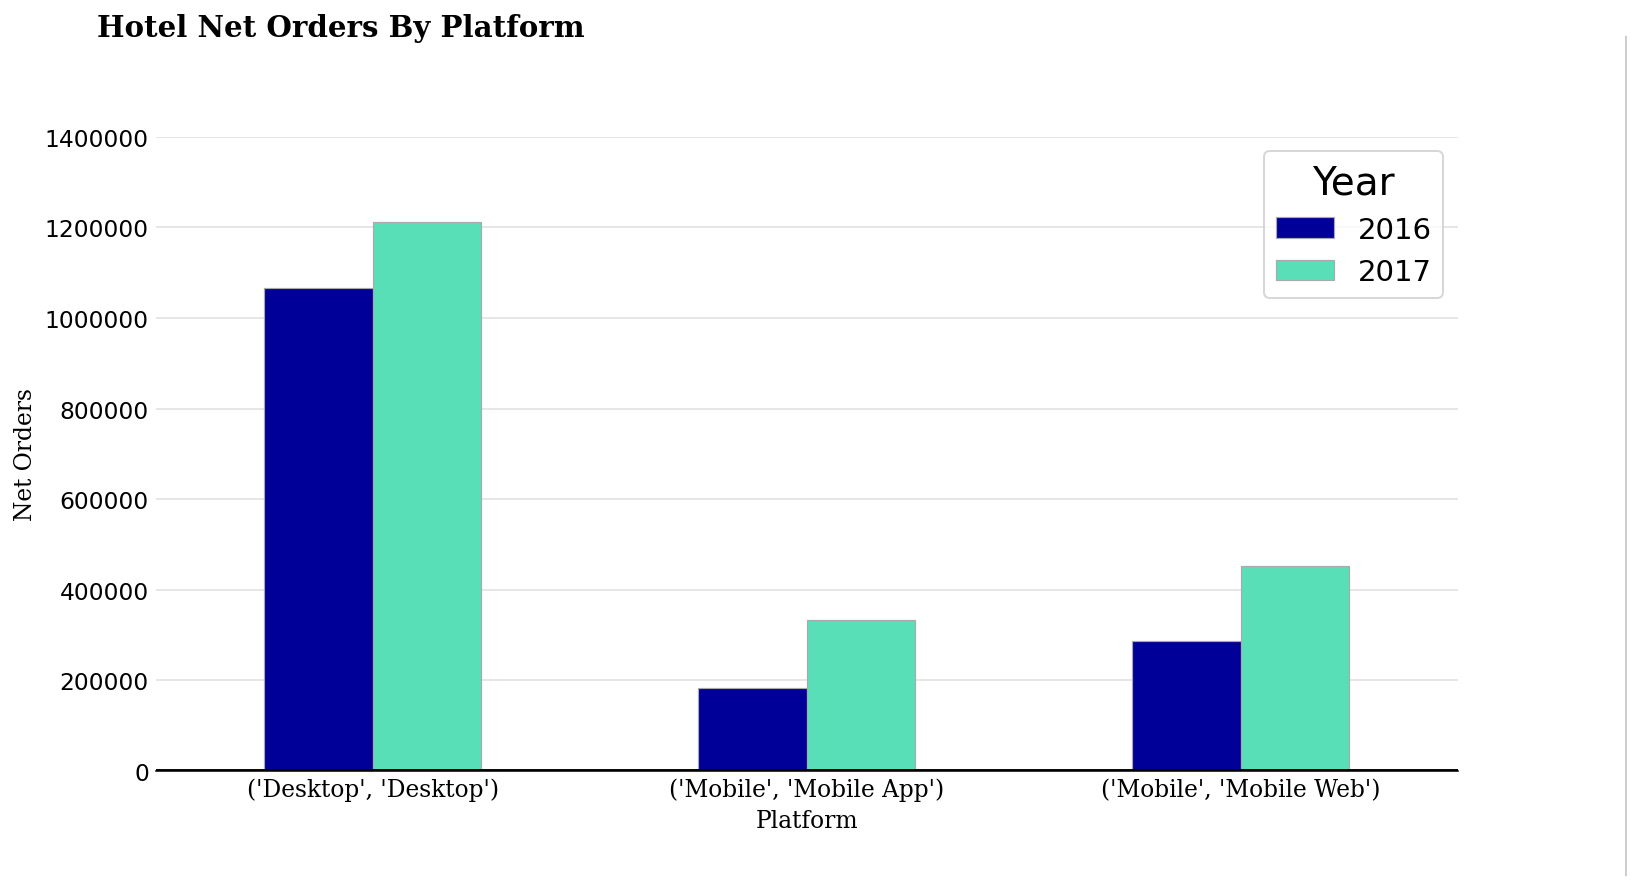

In [701]:
color_map = [c[0], c[3]]
fig, ax = plt.subplots(1,1, figsize=(12, 6))

data.plot(kind='bar', ax=ax,width=0.5, 
       edgecolor='darkgray',
       linewidth=0.6, color=color_map)

# Remove border from plot
for s in ['top', 'left', 'right']:
    ax.spines[s].set_visible(False)
    
# Tick labels
ax.set_xticklabels(data.index, fontfamily='serif', rotation=0)
ax.ticklabel_format(useOffset=False, style='plain', axis='y')

# Title
fig.text(0.09, 1, 'Hotel Net Orders By Platform', fontsize=15, fontweight='bold', fontfamily='serif')

ax.grid(axis='y', linestyle='-', alpha=0.4)

grid_y_ticks = np.arange(0, 1.5*10**6, 0.2*10**6) # y ticks, min, max, then step
ax.set_yticks(grid_y_ticks)
ax.set_axisbelow(True)


# Axis labels

plt.xlabel("Platform", fontsize=12, fontweight='light', fontfamily='serif',y=-1.5)
plt.ylabel("Net Orders", fontsize=12, fontweight='light', fontfamily='serif')
plt.legend(['2016', '2017'],loc='upper right', fontsize=15, title = 'Year', title_fontsize=20)

# thicken the bottom line if you want to
plt.axhline(y = 0, color = 'black', linewidth = 2)

ax.tick_params(axis='both', which='major', labelsize=12)

#removing the tick
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])

ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [726]:
idx=[data.index[i][0] for i in range(len(data.index))]

In [777]:
data = df.groupby(['Year','Mobile Indicator Name', 'Platform Type Name'])[['Net Orders']].sum()
data = data.unstack(level=0)
data

Net Orders         
Year                                           2016     2017
Mobile Indicator Name Platform Type Name                    
Desktop               Desktop               1066185  1211274
Mobile                Mobile App             183998   332541
                      Mobile Web             286114   453567

In [779]:
data.iloc[:,[0]]

Net Orders
Year                                           2016
Mobile Indicator Name Platform Type Name           
Desktop               Desktop               1066185
Mobile                Mobile App             183998
                      Mobile Web             286114

<BarContainer object of 3 artists>

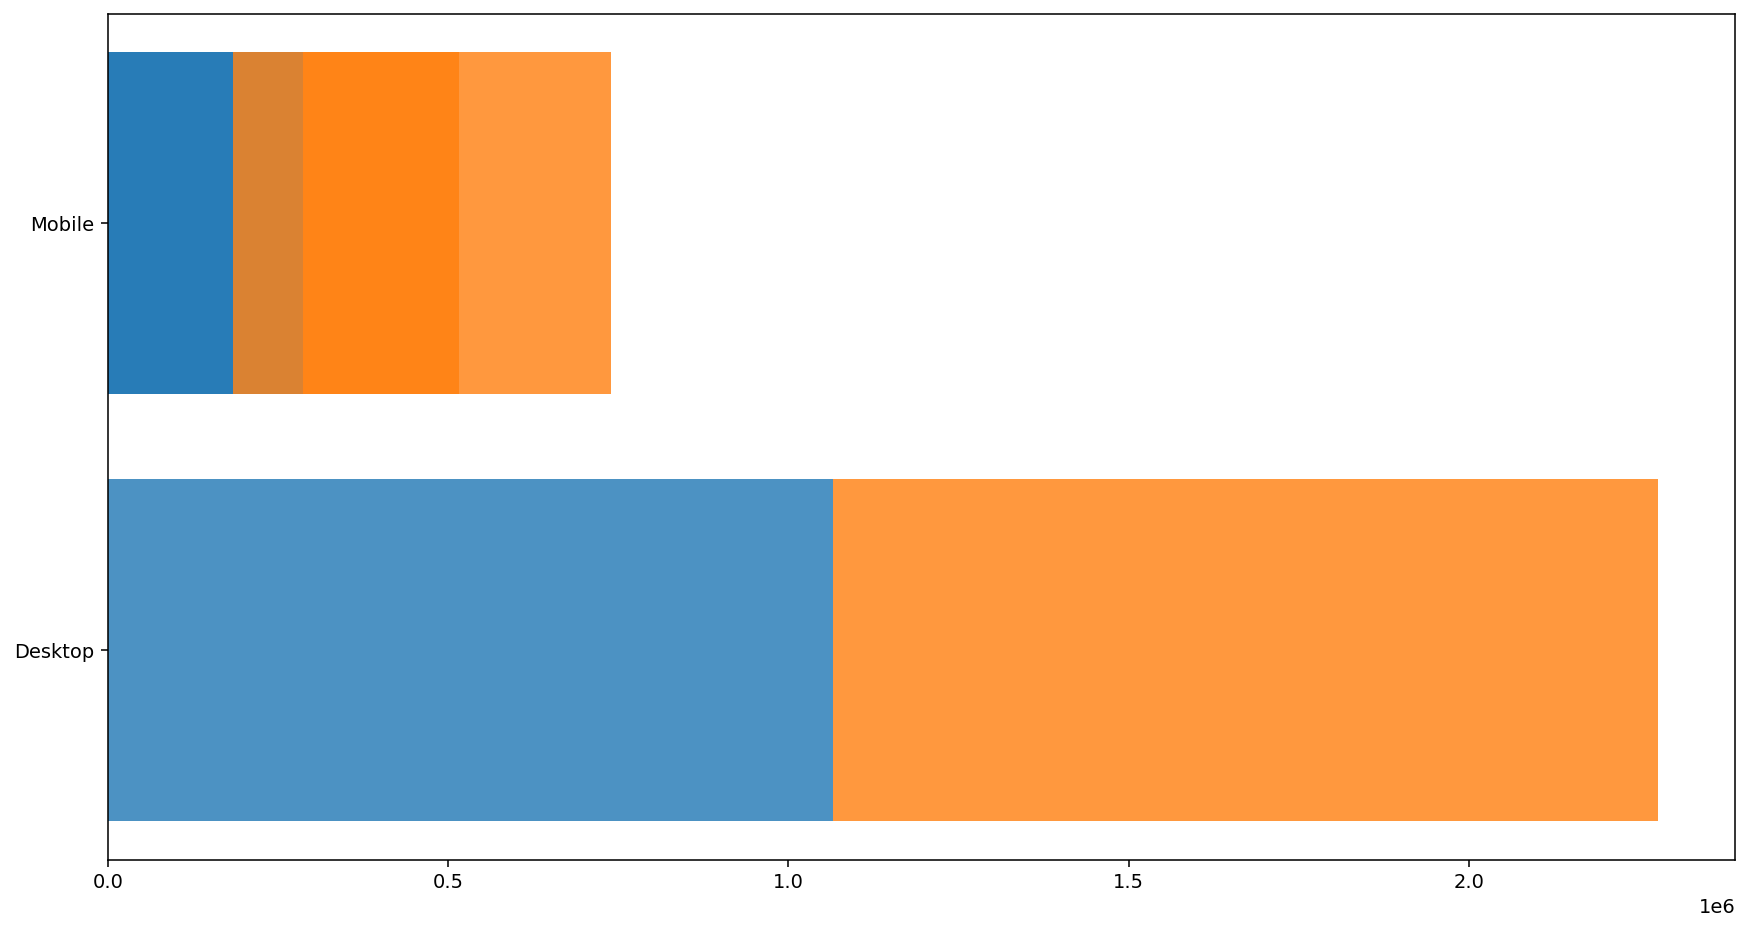

In [741]:
# cols = temp.columns
fig, ax = plt.subplots(1,1,figsize=(15, 8))
ax.barh()

# ax.barh(idx, data.iloc[:,0], alpha=0.8, label='Movie')
# ax.barh(idx, data.iloc[:,1], left=data[('Net Orders', '2016')], alpha=0.8, label='TV Show')

In [179]:
temp = df[df['Year']=='2017'].groupby(['Super Region','Mobile Indicator Name']).agg({'Net Orders': 'sum'})
temp = temp.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
temp = temp.unstack()

In [180]:
temp.index

Index(['APAC', 'EMEA', 'LATAM', 'NA'], dtype='object', name='Super Region')

In [181]:
temp

Net Orders           
Mobile Indicator Name    Desktop     Mobile
Super Region                               
APAC                   56.635677  43.364323
EMEA                   67.378962  32.621038
LATAM                  74.266822  25.733178
NA                     59.500871  40.499129

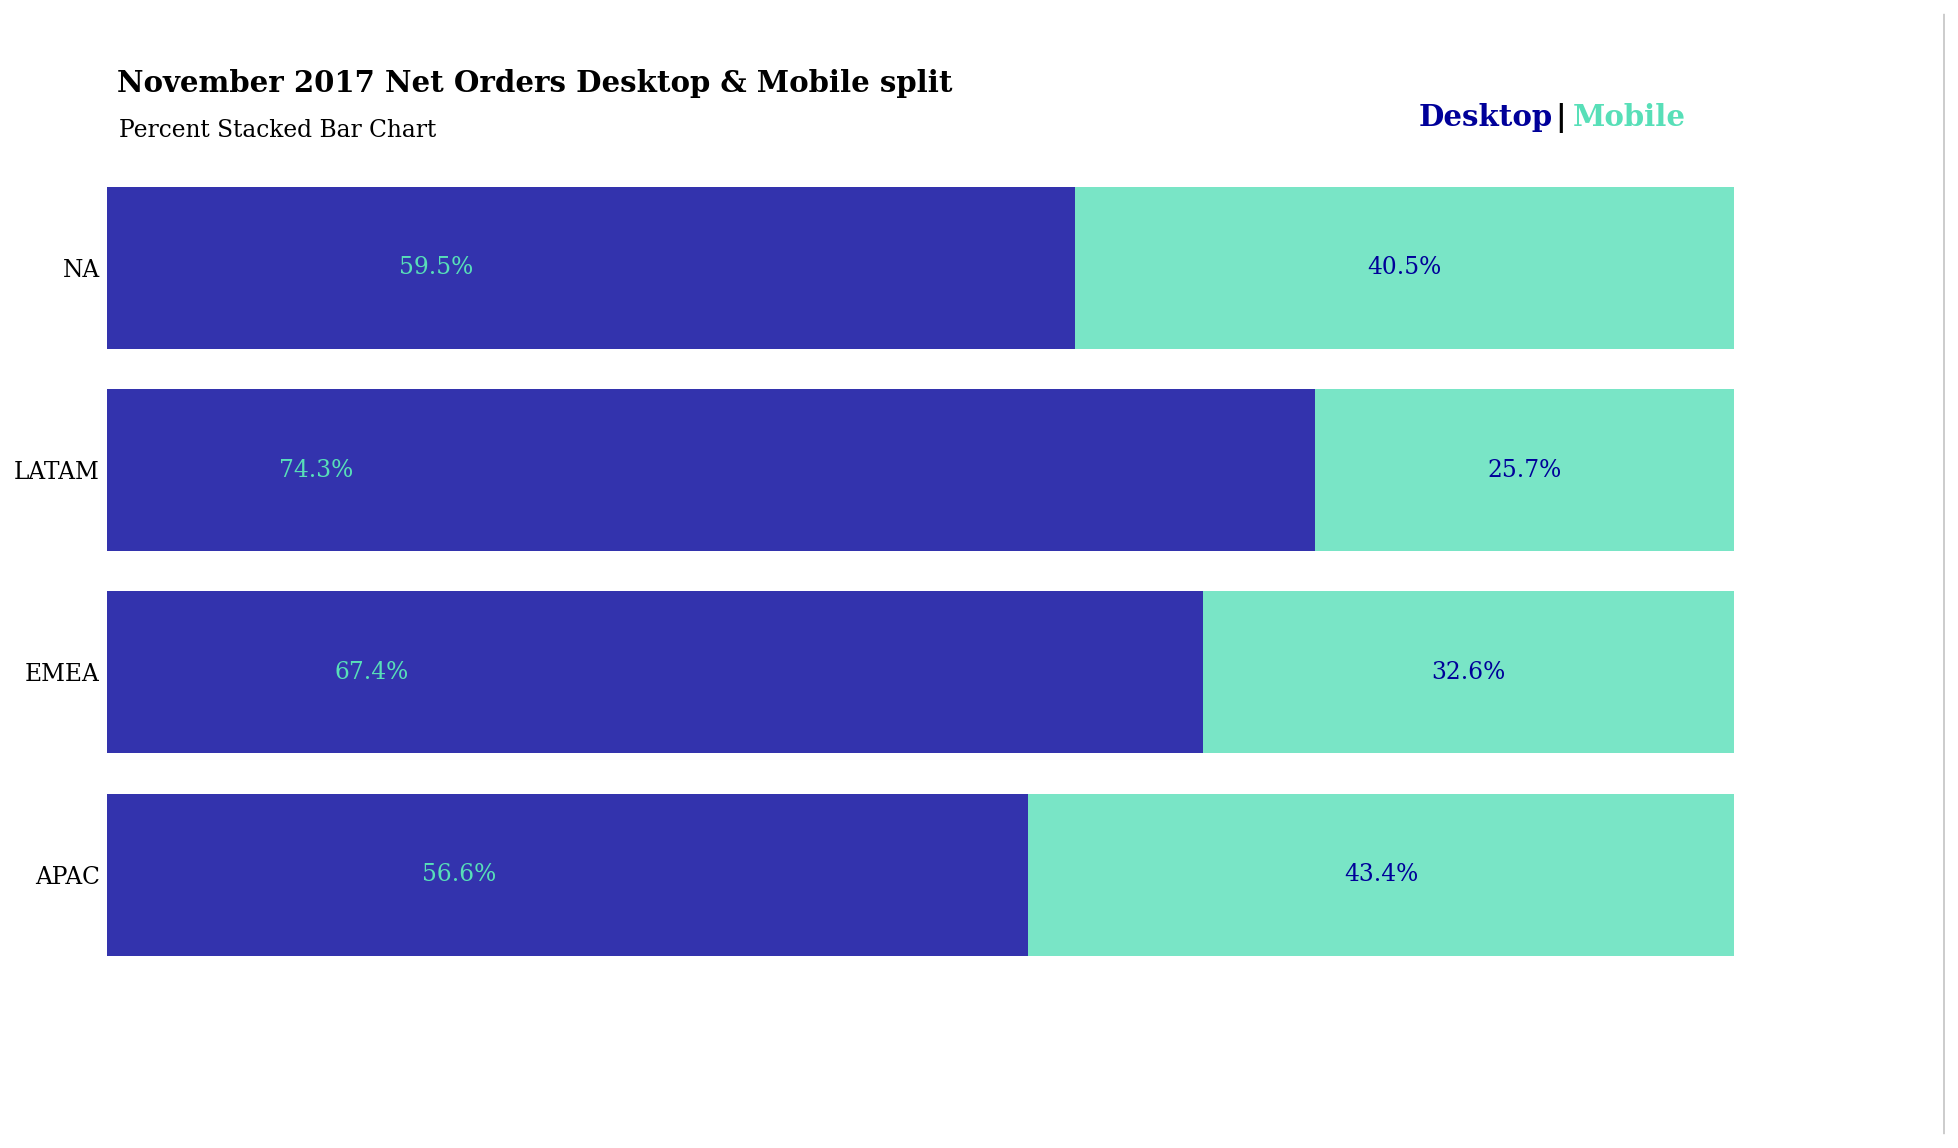

In [183]:
cols = temp.columns
fig, ax = plt.subplots(1,1,figsize=(15, 8),)

ax.barh(temp.index, temp[cols[0]], 
        color=c[0], alpha=0.8, label='Movie')
ax.barh(temp.index, temp[cols[1]], left=temp[('Net Orders', 'Desktop')], 
        color=c[3], alpha=0.8, label='TV Show')


ax.set_xlim(0, 100)
ax.set_xticks([])
ax.set_yticklabels(temp.index, fontfamily='serif', fontsize=11)


for i in temp.index:
    ax.annotate(f"{temp[cols[0]][i]:.3}%", 
                   xy=(temp[cols[1]][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color=c[3])
    
for i in temp.index:
    ax.annotate(f"{temp[cols[1]][i]:.3}%", 
                   xy=(temp[cols[0]][i]+temp[cols[1]][i]/2, i),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color=c[0])
    
    
fig.text(0.13, 0.93, 'November 2017 Net Orders Desktop & Mobile split', fontsize=15, fontweight='bold', fontfamily='serif')   
fig.text(0.131, 0.89, 'Percent Stacked Bar Chart', fontsize=12,fontfamily='serif') 


for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
    
##legend
fig.text(0.75,0.9,"Desktop", fontweight="bold", fontfamily='serif', fontsize=15, color=c[0])
fig.text(0.815,0.9,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.823,0.9,"Mobile", fontweight="bold", fontfamily='serif', fontsize=15, color=c[3])


import matplotlib.lines as lines
l1 = lines.Line2D([1, 1], [0, 1], transform=fig.transFigure, figure=fig,color='black',lw=0.2)
fig.lines.extend([l1])


ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis=u'both', which=u'both',length=0)

plt.show()

In [287]:
temp

Net Orders                                               \
Country Name        Australia     Brazil  Hong Kong     Norway South Korea   
Platform Type Name                                                           
Mobile App           40.63409  41.532751  61.886143  37.279743   69.320362   
Mobile Web           59.36591  58.467249  38.113857  62.720257   30.679638   

                                              
Country Name               US United Kingdom  
Platform Type Name                            
Mobile App          39.370033      34.370442  
Mobile Web          60.629967      65.629558

In [288]:
temp = df[df['Mobile Indicator Name']== 'Mobile'].groupby(['Platform Type Name', 'Country Name'])[['Net Orders']].sum()#.unstack()
temp = temp.groupby(level=1).apply(lambda x: 100 * x / float(x.sum()))
temp = temp.unstack()

app = temp.loc['Mobile App']
web = -temp.loc['Mobile Web']
cols = [i[1] for i in app.index]

In [784]:
df[(df['Mobile Indicator Name']== 'Mobile')].groupby(['Year', 'Booking Window Group'])[['Net Orders']].sum().unstack(level=0)

Net Orders        
Year                       2016    2017
Booking Window Group                   
+90 days                  12261   21865
0-1 days                 254645  396725
15-30 days                40639   72774
2-3 days                  45964   80246
31-45 days                20999   37782
4-7 days                  45049   79223
46-60 days                 9207   18321
61-90 days                 6525   13262
8-14 days                 34808   64803
Post Book                    15    1107

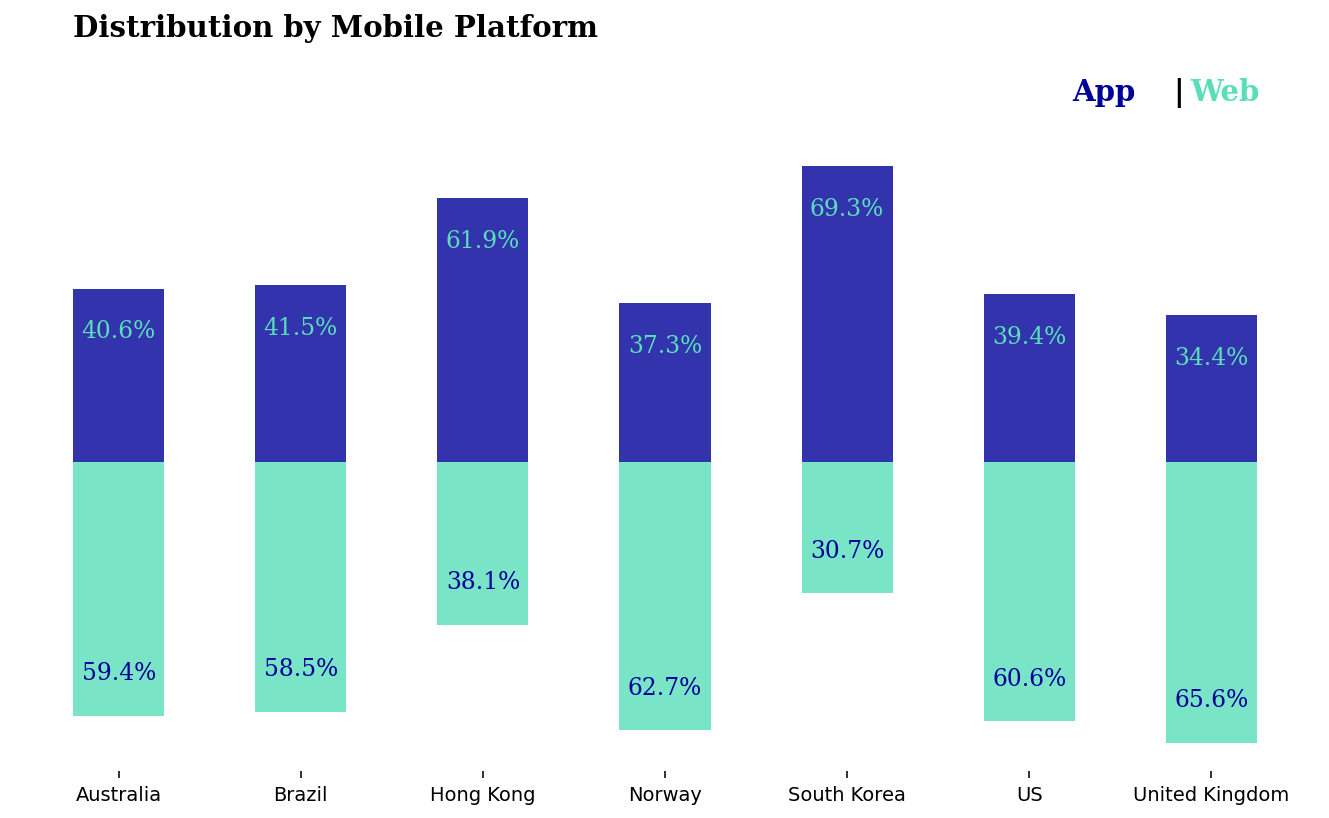

In [313]:
fig, ax = plt.subplots(1,1, figsize=(12, 6))
ax.bar(cols, app, width=0.5, color=c[0], alpha=0.8, label='2016')
ax.bar(cols, web, width=0.5, color=c[3], alpha=0.8, label='2017')


# # Annotations
for i in app.index:
    ax.annotate(f"{app[i]:.3}%", 
                   xy=(i[1], app[i]-10),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color=c[3])

for i in web.index:
    ax.annotate(f"{-web[i]:.3}%", 
                   xy=(i[1], web[i]+10),
                   va = 'center', ha='center',fontsize=12, fontweight='light', fontfamily='serif',
                   color=c[0])
    

for s in ['top', 'left', 'right', 'bottom']:
    ax.spines[s].set_visible(False)
ax.set_yticks([])


ax.legend().set_visible(False)
fig.text(0.16, 1, 'Distribution by Mobile Platform', fontsize=15, fontweight='bold', fontfamily='serif')


fig.text(0.755,0.924,"App", fontweight="bold", fontfamily='serif', fontsize=15, color=c[0])
fig.text(0.815,0.924,"|", fontweight="bold", fontfamily='serif', fontsize=15, color='black')
fig.text(0.825,0.924,"Web", fontweight="bold", fontfamily='serif', fontsize=15, color=c[3])

plt.show()


In [337]:
temp = df[df['Mobile Indicator Name']=='Mobile'].groupby(['Booking Window Group'])['Net Orders'].sum().sort_values(ascending=False)

In [338]:
temp = 100*temp/temp.sum()

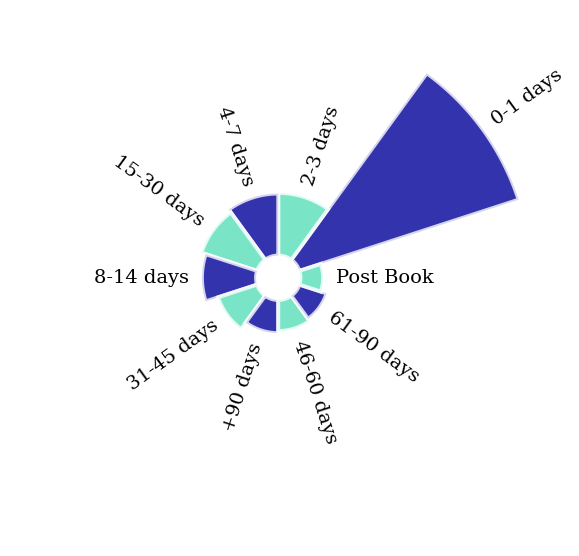

In [356]:
# initialize the figure
plt.figure(figsize=(5,5))
ax = plt.subplot(111, polar=True)
plt.axis('off')

# Constants = parameters controling the plot layout:
upperLimit = 30
lowerLimit = 5
labelPadding = 3


# Compute max and min in the dataset
max_v = temp.max()


# Let's compute heights: they are a conversion of each item value in those new coordinates
# In our example, 0 in the dataset will be converted to the lowerLimit (10)
# The maximum will be converted to the upperLimit (100)
slope = (max_v - lowerLimit) / max_v
heights = slope * temp + lowerLimit


# Compute the width of each bar. In total we have 2*Pi = 360°
width = 2*np.pi / len(temp.index)

# Compute the angle each bar is centered on:
indexes = list(range(1, len(temp.index)+1))
angles = [element * width for element in indexes]
angles

# Draw bars
bars = ax.bar(
    x=angles, 
    height=heights, 
    width=width, 
    bottom=lowerLimit,
    linewidth=2, 
    edgecolor="white",
    color=color_map,alpha=0.8
)

# Add labels
for bar, angle, height, label in zip(bars,angles, heights, temp.index):

    # Labels are rotated. Rotation must be specified in degrees :(
    rotation = np.rad2deg(angle)

    # Flip some labels upside down
    alignment = ""
    if angle >= np.pi/2 and angle < 3*np.pi/2:
        alignment = "right"
        rotation = rotation + 180
    else: 
        alignment = "left"

    # Finally add the labels
    ax.text(
        x=angle, 
        y=lowerLimit + bar.get_height() + labelPadding, 
        s=label, 
        ha=alignment, fontsize=10,fontfamily='serif',
        va='center', 
        rotation=rotation, 
        rotation_mode="anchor") 

## Map Visualization

In [358]:
!pip install pycountry

  Created wheel for pycountry: filename=pycountry-22.1.10-py2.py3-none-any.whl size=10595766 sha256=c5a520940939e6216a51cc5555d103a2602311ccd0694a7c0443ad5b55058347
  Stored in directory: c:\users\tmo0005\appdata\local\pip\cache\wheels\66\06\32\a9179cff2c93a45d140de3a5a4326e9709165681a43ff0f2e7
Successfully built pycountry


In [46]:
import pycountry

In [361]:
# generate country code  based on country name  
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
           # .alpha_3 means 3-letter country code 
           # .alpha_2 means 2-letter country code
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

# create a column for code 
df['CODE']=alpha3code(df['Property Country'])
df.head()

,Week,Mobile Indicator Name,Platform Type Name,Super Region,Country Name,Booking Window Group,Property Country,Net Gross Booking Value USD,Net Orders,Year,CODE
0,W45,Desktop,Desktop,APAC,South Korea,8-14 days,Algeria,-608.4244,-3,2016,DZA
1,W45,Desktop,Desktop,APAC,South Korea,+90 days,Andorra,-512.1796,-2,2016,AND
2,W45,Desktop,Desktop,APAC,South Korea,46-60 days,Andorra,103.4298,1,2016,AND
3,W45,Desktop,Desktop,APAC,Australia,31-45 days,Argentina,395.9592,1,2016,ARG
4,W45,Desktop,Desktop,APAC,Australia,15-30 days,Argentina,373.4194,1,2016,ARG
